Test Notebook to work on Spotify songs' popularity prediction while trying to have a Green AI approach

In [1]:
# Librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecarbon
from codecarbon import EmissionsTracker
import warnings

warnings.filterwarnings("ignore")
import torch

The dataset, quickly

In [2]:
spotify_songs = pd.read_csv("/Users/camille.hascoet/Documents/Green AI/data/tracks.csv")
spotify_songs.head()
# number of rows
dataset_length = len(spotify_songs)
print(dataset_length)

586672


In [3]:
# The 10 most popular songs
spotify_songs.sort_values(by="popularity", ascending=False).head(10)

id                                    name  \
93802  4iJyoBOLtHqaGxP12qzhQI  Peaches (feat. Daniel Caesar & Giveon)   
93803  7lPN2DXiMsVn7XUKtOW1CS                         drivers license   
93804  3Ofmpyhv5UAQ70mENzB277                  Astronaut In The Ocean   
92810  5QO79kh1waicV47BqGRL3g                         Save Your Tears   
92811  6tDDoYIxWvMLTdKpjFkc1B                               telepatía   
93805  7MAibcTli4IisCtbHKrGMh                     Leave The Door Open   
92813  0VjIjW4GlUZAMYd2vXMi3b                         Blinding Lights   
92814  6f3Slt0GbA2bPZlz0aIFXN                            The Business   
92816  3FAJ6O0NOHQV8Mc5Ri6ENp                  Heartbreak Anniversary   
92819  1xK1Gg9SxG8fy2Ya373oqb                                 Bandido   

       popularity  duration_ms  explicit  \
93802         100       198082         1   
93803          99       242014         1   
93804          98       132780         0   
92810          97       215627         1   
92811          97       160191         0   
93805          96       242096         0   
92813          96       200040         0   
92814          95       164000         0   
92816          94       198371         0   
92819          94       232853         0   

                                              artists  \
93802    ['Justin Bieber', 'Daniel Caesar', 'Giveon']   
93803                              ['Olivia Rodrigo']   
93804                                 ['Masked Wolf']   
92810                                  ['The Weeknd']   
92811                                  ['Kali Uchis']   
93805  ['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']   
92813                                  ['The Weeknd']   
92814                                      ['Tiësto']   
92816                                      ['Giveon']   
92819                         ['Myke Towers', 'Juhn']   

                                              id_artists release_date  \
93802  ['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...   2021-03-19   
93803                         ['1McMsnEElThX1knmY4oliG']   2021-01-08   
93804                         ['1uU7g3DNSbsu0QjSEqZtEd']   2021-01-06   
92810                         ['1Xyo4u8uXC1ZmMpatF05PJ']   2020-03-20   
92811                         ['1U1el3k54VvEUzo3ybLPlM']   2020-12-04   
93805  ['0du5cEVh5yTK9QJze8zA0C', '3jK9MiCrA42lLAdMGU...   2021-03-05   
92813                         ['1Xyo4u8uXC1ZmMpatF05PJ']   2020-03-20   
92814                         ['2o5jDhtHVPhrJdv3cEQ99Z']   2020-09-16   
92816                         ['4fxd5Ee7UefO4CUXgwJ7IP']   2020-03-27   
92819  ['7iK8PXO48WeuP03g8YR51W', '2LmcxBak1alK1bf7d1...   2020-12-10   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
93802         0.677   0.696    0    -6.181     1       0.1190       0.32100   
93803         0.585   0.436   10    -8.761     1       0.0601       0.72100   
93804         0.778   0.695    4    -6.865     0       0.0913       0.17500   
92810         0.680   0.826    0    -5.487     1       0.0309       0.02120   
92811         0.653   0.524   11    -9.016     0       0.0502       0.11200   
93805         0.586   0.616    5    -7.964     1       0.0324       0.18200   
92813         0.514   0.730    1    -5.934     1       0.0598       0.00146   
92814         0.798   0.620    8    -7.079     0       0.2320       0.41400   
92816         0.449   0.465    0    -8.964     1       0.0791       0.52400   
92819         0.713   0.617    8    -4.637     1       0.0887       0.12200   

       instrumentalness  liveness  valence    tempo  time_signature  
93802          0.000000    0.4200    0.464   90.030               4  
93803          0.000013    0.1050    0.132  143.874               4  
93804          0.000000    0.1500    0.472  149.996               4  
92810          0.000012    0.5430    0.644  118.051               4  
92811          0.000000    0.2030    0.553   83.970               4  
93805          0

In [4]:
# extract the features
X = spotify_songs.drop(
    ["popularity", "id", "name", "artists", "id_artists", "release_date"], axis=1
)
y = spotify_songs["popularity"]

In [5]:
# find correlation between features and target
correlation = X.corrwith(y)
correlation = correlation.sort_values(ascending=False)
correlation

loudness            0.327028
energy              0.302315
explicit            0.211758
danceability        0.187000
time_signature      0.086759
tempo               0.071364
duration_ms         0.027681
key                 0.015299
valence             0.004643
mode               -0.033655
speechiness        -0.047357
liveness           -0.048740
instrumentalness   -0.236487
acousticness       -0.370882
dtype: float64

In [6]:
X_drop = X.drop(
    ["mode", "valence", "key", "duration_ms", "speechiness", "liveness"], axis=1
)

In [7]:
class NN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 10),
            torch.nn.ReLU(),
        )

        self.output = torch.nn.Linear(10, output_size)

    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.output(x)
        return x


class QAT_NN(torch.nn.Module):
    def __init__(self, model):
        super(QAT_NN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.model = model
        self.dequant = torch.quantization.DeQuantStub()
        self.qconfig = torch.quantization.get_default_qat_qconfig("fbgemm")

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x


def train_model(model, X, y, criterion, optimizer, max_epoch=20):

    model.train()

    emissions_tracker = EmissionsTracker(
        log_level="error", save_to_file=False, save_to_api=False, save_to_logger=False
    )
    emissions_tracker.start()
    emissions_qat = []
    losses_qat = []

    batch_size = 200

    for epoch in range(max_epoch):
        emissions_tracker.start_task()
        for i in range(0, len(X), batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward and optimize

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 2 == 0:
            print(
                "Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, max_epoch, loss.item())
            )
        losses_qat.append(loss.item())
        emissions_qat.append(emissions_tracker.stop_task().emissions)

    total_emissions_qat = emissions_tracker.stop()
    return losses_qat, emissions_qat, total_emissions_qat


def calibrate_model(model, X, device):
    model = model.to(device)
    model = model.eval()
    for x in X:
        x = x.to(device)
        model(x)
    return model

In [8]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_drop)
y_scaled = y.values.reshape(-1, 1) / 100

# shuffle and take 20000 samples
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_scaled, y_scaled, random_state=1234)

X_train = X_shuffled[:20000]
y_train = y_shuffled[:20000]

X_test = X_shuffled[20000:25000]
y_test = y_shuffled[20000:25000]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

input_size = X_train.shape[1]
hidden_size = 400
output_size = 1

In [9]:
model_normal = NN(input_size, hidden_size, output_size)

normal_criterion = torch.nn.L1Loss()
normal_optimizer = torch.optim.Adam(model_normal.parameters(), lr=0.01)

losses_normal, emissions_normal, total_emissions_normal = train_model(
    model_normal, X_train, y_train, normal_criterion, normal_optimizer
)

Epoch [2/20], Loss: 0.1596
Epoch [4/20], Loss: 0.1596
Epoch [6/20], Loss: 0.1597
Epoch [8/20], Loss: 0.1597
Epoch [10/20], Loss: 0.1597
Epoch [12/20], Loss: 0.1597
Epoch [14/20], Loss: 0.1597
Epoch [16/20], Loss: 0.1598
Epoch [18/20], Loss: 0.1598
Epoch [20/20], Loss: 0.1596


In [10]:
import copy

model_to_quantize = copy.deepcopy(model_normal)
model_int8 = QAT_NN(model_to_quantize)

model_int8.qconfig = torch.quantization.get_default_qconfig("fbgemm")
torch.quantization.prepare_qat(model_int8, inplace=True)
int8_optimizer = torch.optim.Adam(model_int8.parameters(), lr=0.01)

losses_qat, emissions_qat, total_emissions_qat = train_model(
    model_int8, X_train, y_train, normal_criterion, int8_optimizer
)

model_int8 = torch.quantization.convert(model_int8, inplace=True)

Epoch [2/20], Loss: 0.1598
Epoch [4/20], Loss: 0.1598
Epoch [6/20], Loss: 0.1598
Epoch [8/20], Loss: 0.1598
Epoch [10/20], Loss: 0.1598
Epoch [12/20], Loss: 0.1598
Epoch [14/20], Loss: 0.1596
Epoch [16/20], Loss: 0.1597
Epoch [18/20], Loss: 0.1597
Epoch [20/20], Loss: 0.1598


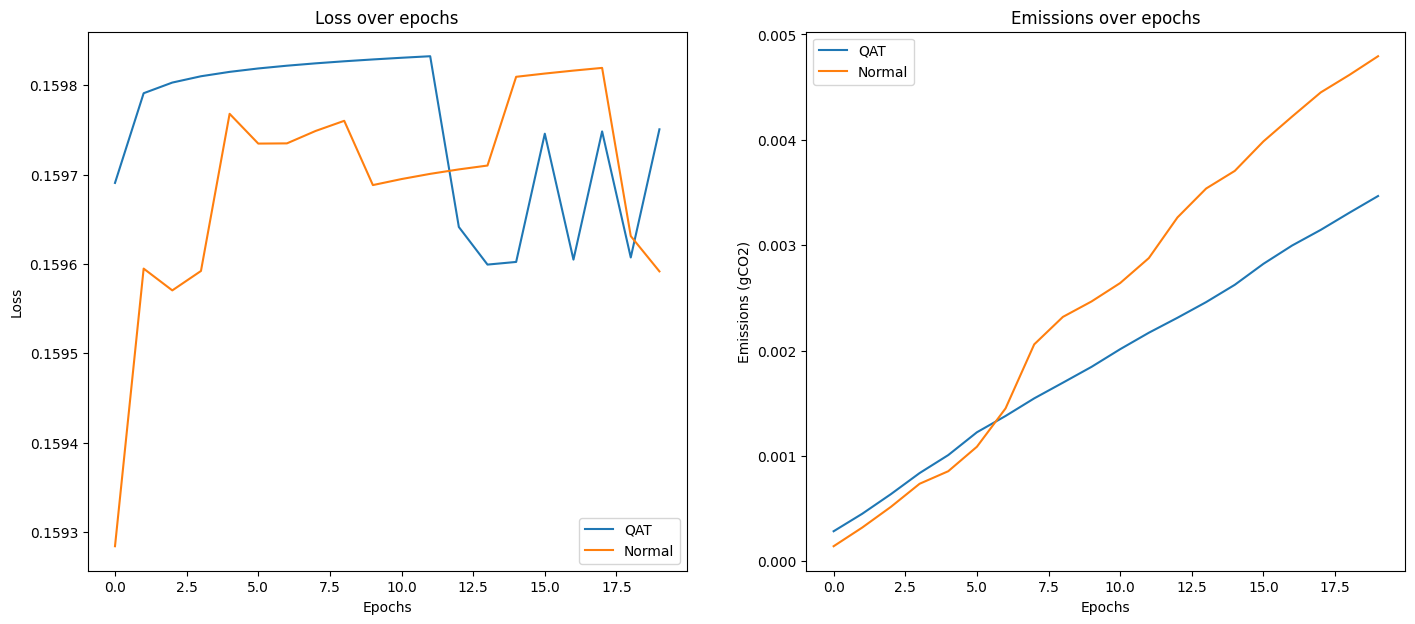

In [11]:
# compare the emissions and losses over the epochs
cumsum_emissions_qat = np.cumsum(emissions_qat) * 1000
cumsum_emissions_normal = np.cumsum(emissions_normal) * 1000

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.plot(losses_qat, label="QAT")
plt.plot(losses_normal, label="Normal")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cumsum_emissions_qat, label="QAT")
plt.plot(cumsum_emissions_normal, label="Normal")
plt.title("Emissions over epochs")
plt.xlabel("Epochs")
plt.ylabel("Emissions (gCO2)")
plt.legend()
plt.show()

In [12]:
print("Total emissions QAT: {:.4f} gCO2".format(total_emissions_qat * 1000))

print("Total emissions Normal: {:.4f} gCO2".format(total_emissions_normal * 1000))

Total emissions QAT: 0.0035 gCO2
Total emissions Normal: 0.0048 gCO2


In [13]:
# compare both models inference time
import time
import codecarbon
from codecarbon import EmissionsTracker


def inference_time(model, X_test, num_iterations=100, warm_up=10):

    tracker = EmissionsTracker(
        log_level="critical",
        save_to_file=False,
        save_to_api=False,
        save_to_logger=False,
    )
    tracker.start()

    model = model.eval()

    for i in range(warm_up):
        model(X_test)

    start = time.time()

    for i in range(num_iterations):
        model(X_test)

    end = time.time()
    total_emissions = tracker.stop()

    return (end - start) / num_iterations, total_emissions / num_iterations

In [14]:
int8_inference_time, int8_emissions = inference_time(model_int8, X_test)

fp32_inference_time, fp32_emissions = inference_time(model_normal, X_test)

print(f"FP32 Inference Time: {fp32_inference_time}")

print(f"INT8 Inference Time: {int8_inference_time}")

FP32 Inference Time: 0.019961390495300293
INT8 Inference Time: 0.012851719856262206


In [17]:
# dataframe of the results
results = pd.DataFrame(
    {
        "Model": ["Normal", "QAT"],
        "Inference time (s)": [fp32_inference_time, int8_inference_time],
        "Inferece emissions (gCO2)": [fp32_emissions * 1000, int8_emissions * 1000],
        "Loss": [losses_normal[-1], losses_qat[-1]],
        "Training emissions (gCO2)": [
            total_emissions_normal * 1000,
            total_emissions_qat * 1000,
        ],
    }
)

results

Model  Inference time (s)  Inferece emissions (gCO2)      Loss  \
0  Normal            0.019961                   0.000005  0.159592   
1     QAT            0.012852                   0.000003  0.159751   

   Training emissions (gCO2)  
0                   0.004795  
1                   0.003467

In [16]:
import os


def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" % (os.path.getsize("tmp.pt") / 1e6))
    os.remove("tmp.pt")


print_model_size(model_normal)

print_model_size(model_int8)

1.32 MB
0.36 MB
